|                  符号                   |     意义     | 单位 |      |              符号               |     意义     |   单位    |
| :-------------------------------------: | :----------: | :--: | :--: | :-----------------------------: | :----------: | :-------: |
|             $n_0 \approx 1$             |  空气折射率  |      |      |           $\theta_0$            |  空气入射角  |    rad    |
|            $n_1 \approx 2.5$            | 外延层折射率 |      |      |           $\theta_1$            | 外延层折射角 |    rad    |
|                  $n_2$                  |  衬底折射率  |      |      |               $d$               |  外延层厚度  |    μm     |
|                $\Delta$                 |    光程差    |  m   |      | $\lambda = \frac{1}{\tilde{v}}$ |     波长     |    μm     |
| $\delta = \frac{2 \pi}{\lambda} \Delta$ |    相位差    | rad  |      | $\tilde{v} = \frac{1}{\lambda}$ |     波数     | cm$^{-1}$ |

光程差：
$$\Delta = 2 n_1 d \cos \theta_1 + \frac{\lambda}{2}$$
其中，由于半波损失，所以需要 $+ \frac{\lambda}{2}$

相位差：
$$\delta = 4 \pi n_1 d \cos \theta_1 \tilde{v} + \pi$$

干涉相长的条件（相位差为0或者整数倍）：
$$\delta = 2 \pi m, m \in \mathbb{Z}$$
干涉相消的条件（相位差为半波长的奇数倍）：
$$\delta = (2 m + 1) \pi, m \in \mathbb{Z}$$
如果出现干涉相长，那么就会出现波峰；如果出现干涉相消，那么就会出现波谷。

某个波峰的波数为：
$$\tilde{v}_m = \frac{2 \pi m - \pi}{4 \pi n_1 d \cos \theta_1} = \frac{2 m - 1}{4 n_1 d \cos \theta_1}$$

两个相邻波峰的波数差为：
$$\Delta \tilde{v}_m = \tilde{v}_m - \tilde{v}_{m-1} = \frac{1}{2 n_1 d \cos \theta_1}$$

波谷同理，某个波谷的波数为：
$$\tilde{v}_m = \frac{(2m+1)\pi - \pi}{4 \pi n_1 d \cos \theta_1} = \frac{m}{2 n_1 d \cos \theta_1}$$

两个相邻波谷的波数差为：
$$\Delta \tilde{v}_m = \tilde{v}_m - \tilde{v}_{m-1} = \frac{1}{2 n_1 d \cos \theta_1}$$

所以外延层厚度：
$$d = \frac{1}{2 n_1 \cos \theta_1 \Delta \tilde{v}}$$
其中，$\Delta \tilde{v}$ 为相邻波峰或波谷的波数差，通过对多个波峰或波谷的波数差取平均可以得到

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
n0 = 1
n1 = 2.5
theta0 = np.deg2rad(10)
theta1 = np.arcsin(n0 * np.sin(theta0) / n1)
np.rad2deg(theta1)

3.982930136721576

In [3]:
attach1 = pd.read_excel('附件1.xlsx')
attach2 = pd.read_excel('附件2.xlsx')
attach1

,波数 (cm-1),反射率 (%)
0,399.6747,0.000000
1,400.1569,31.293229
2,400.6390,30.604280
3,401.1211,29.997402
4,401.6032,29.414797
...,...,...
7464,3998.1940,18.270606
7465,3998.6760,18.273895
7466,3999.1580,18.254891
7467,3999.6400,18.302167


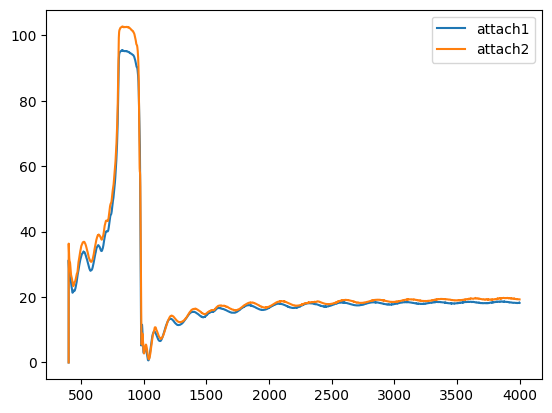

In [4]:
plt.plot(attach1.iloc[:, 0], attach1.iloc[:, 1], label='attach1')
plt.plot(attach2.iloc[:, 0], attach2.iloc[:, 1], label='attach2')
plt.legend()
plt.show()

In [5]:
def plot(x, x_smooth, idx):
    plt.plot(x, label='original')
    plt.plot(x_smooth, label='smoothed')
    plt.scatter(idx, x_smooth[idx], c='r', label='peaks')
    plt.grid()
    # plt.legend()
    # plt.show()

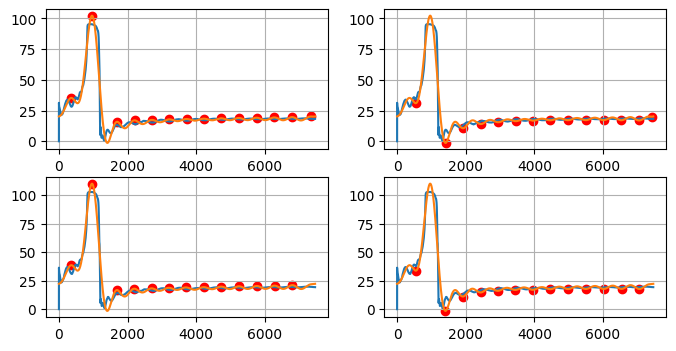

In [ ]:
from scipy.signal import savgol_filter, find_peaks
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.nonparametric.smoothers_lowess import lowess

alpha = 0.3
window_length = window_size = 11
poly_order = 4
distance = 100
frac = 0.1

def fft_smooth(data, cutoff_freq=0.002):
    fft_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data))
    filter_mask = np.abs(freqs) < cutoff_freq  # 保留低频成分，滤除高频成分
    filtered_fft = fft_data * filter_mask
    smoothed_data = np.fft.ifft(filtered_fft)
    return np.real(smoothed_data)

def smooth_and_find_peaks(x):
    x_smooth = fft_smooth(x)  # 平滑1
    # x_smooth = savgol_filter(x, window_length, poly_order)  # 平滑2
    # x_smooth = np.convolve(x, np.ones(window_size)/window_size, mode='valid')  # 平滑3
    # x_smooth = SimpleExpSmoothing(x).fit(smoothing_level=alpha).fittedvalues  # 平滑4
    # x_smooth = lowess(x, np.arange(len(x)), frac=frac)[:, 1]  # 平滑5
    peaks, props = find_peaks(x_smooth, height=np.max(x_smooth) * 0.1, distance=distance)
    return x_smooth, peaks
# 找到波谷
def smooth_and_find_troughs(x):
    x_smooth = fft_smooth(x)
    # x_smooth = savgol_filter(x, window_length, poly_order)
    # x_smooth = np.convolve(x, np.ones(window_size)/window_size, mode='valid')
    # x_smooth = SimpleExpSmoothing(x).fit(smoothing_level=alpha).fittedvalues
    # x_smooth = lowess(x, np.arange(len(x)), frac=frac)[:, 1]
    _x = x_smooth.max() - x_smooth
    troughs, props = find_peaks(_x, height=np.max(_x) * 0.1, distance=distance)
    return x_smooth, troughs

plt.figure(figsize=(8, 4))

theta0 = np.deg2rad(10)
theta1 = np.arcsin(n0 * np.sin(theta0) / n1)
tilde_v, R = attach1.values.T

R_smooth, R_peaks_idx = smooth_and_find_peaks(R)
R_peaks = R_smooth[R_peaks_idx]
plt.subplot(221)
plot(R, R_smooth, R_peaks_idx)

R_smooth, R_troughs_idx = smooth_and_find_troughs(R)
R_troughs = R_smooth[R_troughs_idx]
plt.subplot(222)
plot(R, R_smooth, R_troughs_idx)

theta0 = np.deg2rad(15)
theta1 = np.arcsin(n0 * np.sin(theta0) / n1)
tilde_v, R = attach2.values.T

R_smooth, R_peaks_idx = smooth_and_find_peaks(R)
R_peaks = R_smooth[R_peaks_idx]
plt.subplot(223)
plot(R, R_smooth, R_peaks_idx)

R_smooth, R_troughs_idx = smooth_and_find_troughs(R)
R_troughs = R_smooth[R_troughs_idx]
plt.subplot(224)
plot(R, R_smooth, R_troughs_idx)

plt.show()

平滑的效果一般，观察波数差大约为 $\frac{500}{3} \sim \frac{500}{2}$

In [7]:
# 附件1：波峰
theta0 = np.deg2rad(10)
theta1 = np.arcsin(n0 * np.sin(theta0) / n1)
tilde_v, R = attach1.values.T
R_smooth, R_peaks_idx = smooth_and_find_peaks(R)
# R_peaks = R_smooth[R_peaks_idx]
Delta_tilde_v = np.diff(tilde_v[R_peaks_idx])
# print(Delta_tilde_v)
Delta_tilde_v_const = 500 / 2
Delta_tilde_v_median = np.median(Delta_tilde_v)
Delta_tilde_v_mean = Delta_tilde_v.mean()
Delta_tilde_v_std = Delta_tilde_v.std()
print('median', Delta_tilde_v_median, 'mean:', Delta_tilde_v_mean, 'std:', Delta_tilde_v_std)
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_const) * 1e4, \
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_median) * 1e4, \
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_mean) * 1e4  # cm -> um

median 247.8090000000002 mean: 259.0820769230769 std: 29.859911630611524


(8.019368473305653, 8.09027161372836, 7.738250913133073)

In [8]:
# 附件1：波谷
theta0 = np.deg2rad(10)
theta1 = np.arcsin(n0 * np.sin(theta0) / n1)
tilde_v, R = attach1.values.T
R_smooth, R_troughs_idx = smooth_and_find_troughs(R)
# R_troughs = R_smooth[R_troughs_idx]
Delta_tilde_v = np.diff(tilde_v[R_troughs_idx])
# print(Delta_tilde_v)
Delta_tilde_v_const = 500 / 2
Delta_tilde_v_median = np.median(Delta_tilde_v)
Delta_tilde_v_mean = Delta_tilde_v.mean()
Delta_tilde_v_std = Delta_tilde_v.std()
print('median', Delta_tilde_v_median, 'mean:', Delta_tilde_v_mean, 'std:', Delta_tilde_v_std)
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_const) * 1e4, \
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_median) * 1e4, \
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_mean) * 1e4  # cm -> um

median 247.32600000000002 mean: 255.33639230769234 std: 50.75658583869396


(8.019368473305653, 8.106071008815945, 7.8517680155458764)

In [9]:
# 附件2：波峰
theta0 = np.deg2rad(15)
theta1 = np.arcsin(n0 * np.sin(theta0) / n1)
tilde_v, R = attach2.values.T
R_smooth, R_peaks_idx = smooth_and_find_peaks(R)
# R_peaks = R_smooth[R_peaks_idx]
Delta_tilde_v = np.diff(tilde_v[R_peaks_idx])
# print(Delta_tilde_v)
Delta_tilde_v_const = 500 / 2
Delta_tilde_v_median = np.median(Delta_tilde_v)
Delta_tilde_v_mean = Delta_tilde_v.mean()
Delta_tilde_v_std = Delta_tilde_v.std()
print('median', Delta_tilde_v_median, 'mean:', Delta_tilde_v_mean, 'std:', Delta_tilde_v_std)
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_const) * 1e4, \
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_median) * 1e4, \
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_mean) * 1e4  # cm -> um

median 250.21849999999995 mean: 258.816325 std: 30.604397068589243


(8.043219602493455, 8.036195967218108, 7.769235192653955)

In [10]:
# 附件2：波谷
theta0 = np.deg2rad(15)
theta1 = np.arcsin(n0 * np.sin(theta0) / n1)
tilde_v, R = attach2.values.T
R_smooth, R_troughs_idx = smooth_and_find_troughs(R)
# R_troughs = R_smooth[R_troughs_idx]
Delta_tilde_v = np.diff(tilde_v[R_troughs_idx])
# print(Delta_tilde_v)
Delta_tilde_v_const = 500 / 2
Delta_tilde_v_median = np.median(Delta_tilde_v)
Delta_tilde_v_mean = Delta_tilde_v.mean()
Delta_tilde_v_std = Delta_tilde_v.std()
print('median', Delta_tilde_v_median, 'mean:', Delta_tilde_v_mean, 'std:', Delta_tilde_v_std)
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_const) * 1e4, \
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_median) * 1e4, \
1 / (2 * n1 * np.cos(theta1) * Delta_tilde_v_mean) * 1e4  # cm -> um

median 249.2544999999999 mean: 261.95005833333335 std: 47.00291453485373


(8.043219602493455, 8.067276220182041, 7.676291096925812)

可靠性可以从两个附件结果对比得到，另外波数差的方差在一定程度上也能反映，但是最终结果取决于数据平滑的效果